# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.46KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

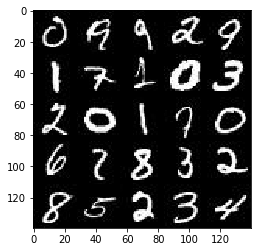

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

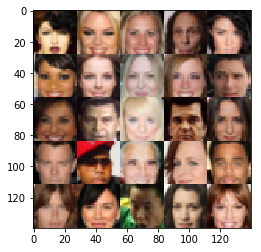

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    Input = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name = 'input')
    z = tf.placeholder(tf.float32,[None,z_dim],name = 'Targets')
    LearingRate = tf.placeholder(tf.float32,None,name = 'LearingRate')

    return Input, z, LearingRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    dropout_rate = 0.8
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator",reuse=reuse):

        shape = images.get_shape().as_list()
        channels = shape[3]
        
        x1 = tf.layers.conv2d(images,64,channels,strides=2,padding='same') 
        relu1 = tf.maximum(alpha * x1, x1) #leaky relu
        drop1 = tf.layers.dropout(relu1,dropout_rate)

        x2 = tf.layers.conv2d(drop1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha* bn2, bn2)
        drop2 = tf.layers.dropout(relu2,dropout_rate)


        x3 = tf.layers.conv2d(drop2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha* bn3, bn3)
        drop3 = tf.layers.dropout(relu3,dropout_rate)
        
        # Flatten it
        flat=tf.contrib.layers.flatten(drop3)
        logits = tf.layers.dense(flat,1)
        output=tf.sigmoid(logits)

        return logits, output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    dropout_rate = 0.8
    
    with tf.variable_scope("generator",reuse=reuse):

        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,shape=(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train) 
        x1 = tf.maximum(alpha * x1, x1) #leaky relu

        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization( x3,training=is_train)
        x3 = tf.maximum(alpha* x3, x3)

        #output layer
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same')
        
        output = tf.tanh(logits)

        return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_logits_real, d_output_real = discriminator(input_real, reuse=False)
    d_logits_fake, d_output_fake = discriminator(g_model, reuse=True) 
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)*0.9))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)*0.9))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

   # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, 
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    
    print_every=10
    show_every=100
    
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              # TODO: Train Model
                steps += 1
                # batch_images = 2* batch_images

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               lr: learning_rate})
                
                # Call generators multiple times
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)  
                              
    return losses                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 1.3405
Epoch 1/2... Discriminator Loss: 2.5725... Generator Loss: 0.3408
Epoch 1/2... Discriminator Loss: 2.0458... Generator Loss: 1.6472
Epoch 1/2... Discriminator Loss: 1.7505... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 2.1288... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.5003
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 3.0326
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 1.7334


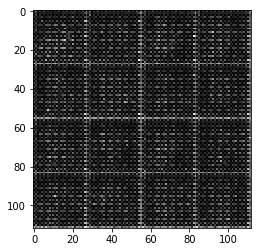

Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 2.0485
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.3504... Generator Loss: 4.0107
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 5.4936... Generator Loss: 6.5242
Epoch 1/2... Discriminator Loss: 1.8021... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 2.2071... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 1.6716
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.0472


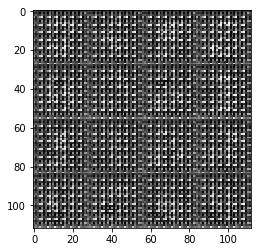

Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.5309
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 2.2064... Generator Loss: 0.3597
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.1981
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.8178
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 2.7017
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 2.5466


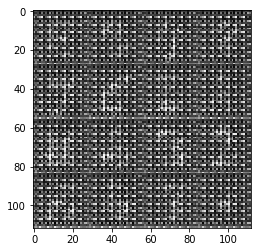

Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 1.6467
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.9966
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 4.2125
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 2.4679
Epoch 1/2... Discriminator Loss: 0.4528... Generator Loss: 2.4358
Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.4764


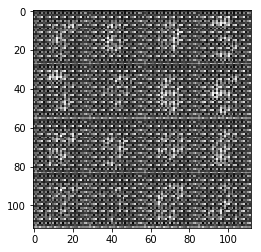

Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 0.6069... Generator Loss: 1.4311
Epoch 1/2... Discriminator Loss: 1.7068... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.5750
Epoch 1/2... Discriminator Loss: 1.9445... Generator Loss: 5.0833
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 0.8262


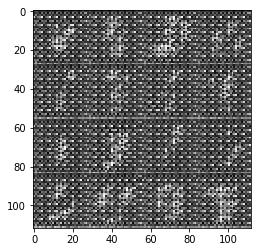

Epoch 1/2... Discriminator Loss: 2.3926... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 3.6951
Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 1.8195
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 5.3392
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.4699
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 1.7687
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 4.0507
Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 4.0188


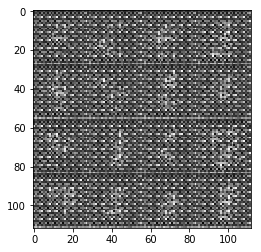

Epoch 1/2... Discriminator Loss: 2.5745... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 2.9274
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 5.9500
Epoch 1/2... Discriminator Loss: 0.7986... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 0.3934... Generator Loss: 2.7978
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.6700
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 3.6747
Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 0.5052
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 0.9505
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.5637


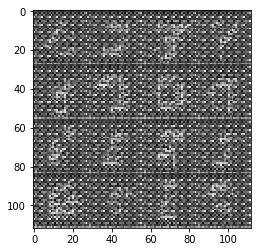

Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 2.7563
Epoch 1/2... Discriminator Loss: 2.5858... Generator Loss: 0.3379
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.2934
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 0.4812
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 3.4299
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 7.9172
Epoch 1/2... Discriminator Loss: 2.4224... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 7.4063
Epoch 1/2... Discriminator Loss: 0.3583... Generator Loss: 3.9630


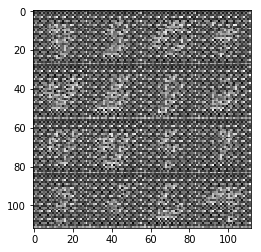

Epoch 1/2... Discriminator Loss: 2.3690... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 2.0784... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.7362... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 5.8807
Epoch 1/2... Discriminator Loss: 3.7707... Generator Loss: 0.3782
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 5.2223
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 4.4706
Epoch 1/2... Discriminator Loss: 2.9142... Generator Loss: 0.3464


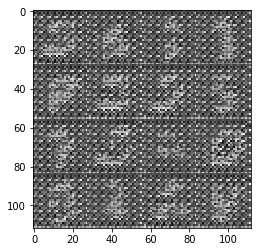

Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 3.7285
Epoch 1/2... Discriminator Loss: 3.5152... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 3.1050... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 2.9218... Generator Loss: 0.3456
Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 4.5292
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.5439
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 6.1688
Epoch 1/2... Discriminator Loss: 0.5147... Generator Loss: 4.6683
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 1.8339


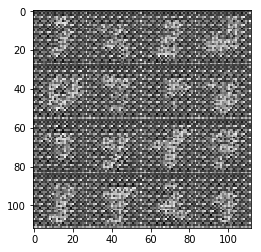

Epoch 1/2... Discriminator Loss: 2.2233... Generator Loss: 0.3653
Epoch 1/2... Discriminator Loss: 2.8408... Generator Loss: 0.3360
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 2.0112... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 3.2284
Epoch 1/2... Discriminator Loss: 2.2653... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 4.6110
Epoch 1/2... Discriminator Loss: 2.6773... Generator Loss: 0.3404
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 2.0070


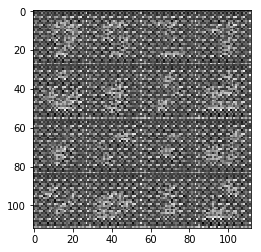

Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.4578
Epoch 1/2... Discriminator Loss: 1.9146... Generator Loss: 0.3878
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 1.4778
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.8432
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.0827
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 1.2641
Epoch 1/2... Discriminator Loss: 2.5350... Generator Loss: 0.3423


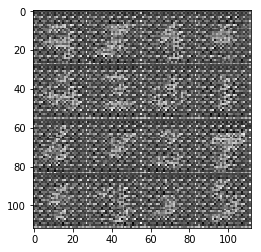

Epoch 1/2... Discriminator Loss: 2.8326... Generator Loss: 0.3337
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 3.1511
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.4564
Epoch 1/2... Discriminator Loss: 2.1395... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 2.4931... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 1.2510
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 2.0984
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 2.6373


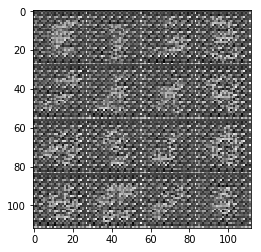

Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.5464
Epoch 1/2... Discriminator Loss: 0.8451... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 1.5883
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.5901
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 2.1556
Epoch 1/2... Discriminator Loss: 2.0283... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 2.0384
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 1.8693... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 0.9923


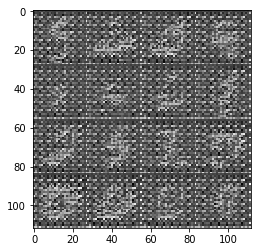

Epoch 1/2... Discriminator Loss: 2.0593... Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 2.7603
Epoch 1/2... Discriminator Loss: 2.3407... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 2.0747... Generator Loss: 0.3657
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 3.6221
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 2.0992... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.8127... Generator Loss: 0.4079


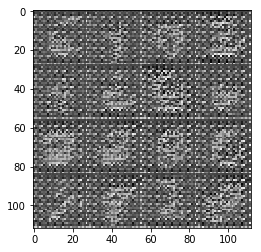

Epoch 1/2... Discriminator Loss: 2.1876... Generator Loss: 0.3764
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 2.8397
Epoch 1/2... Discriminator Loss: 1.7473... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 2.1095... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 1.9442... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 2.2192... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.6645


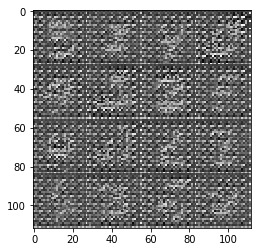

Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.4485
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.6322
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.1942
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 4.5474
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 1.7904... Generator Loss: 0.4263


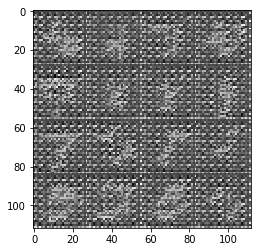

Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 2.2909... Generator Loss: 0.3647
Epoch 1/2... Discriminator Loss: 2.1599... Generator Loss: 0.3844
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 1.5950... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 2.2269
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.5208
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 2.5951


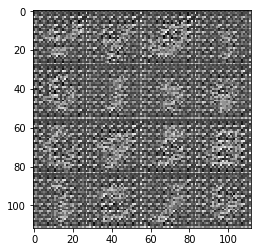

Epoch 1/2... Discriminator Loss: 1.6461... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 2.0015
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 1.3549
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 0.8737
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.9799... Generator Loss: 0.3935
Epoch 2/2... Discriminator Loss: 1.7752... Generator Loss: 0.4663


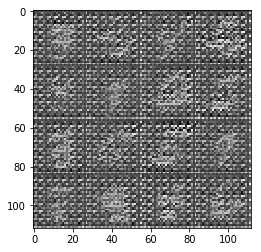

Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 2.2025
Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 4.4094
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.6150
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.5661
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.6590... Generator Loss: 0.4550


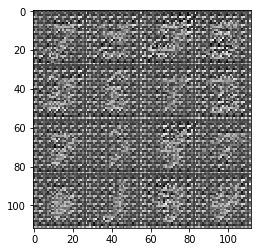

Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 4.4677
Epoch 2/2... Discriminator Loss: 1.7384... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 0.4437... Generator Loss: 2.2306
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 2.6177
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.5939


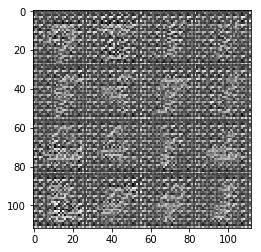

Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 2.5159
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.8094
Epoch 2/2... Discriminator Loss: 2.5658... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.4638
Epoch 2/2... Discriminator Loss: 1.6438... Generator Loss: 0.4668


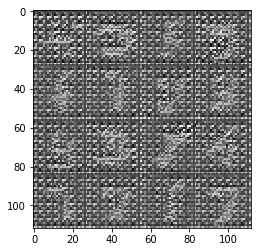

Epoch 2/2... Discriminator Loss: 2.3107... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 1.8799
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 2.0403... Generator Loss: 0.4118
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.9307


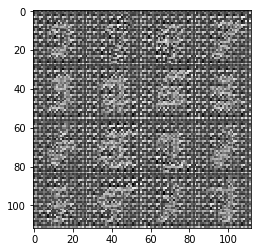

Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 1.7831
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.1601


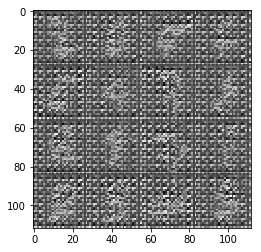

Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.0971
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 2.1912... Generator Loss: 0.3683
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 2.0766... Generator Loss: 0.3946


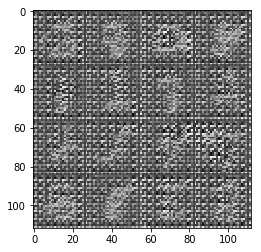

Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 2.2174
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.5429
Epoch 2/2... Discriminator Loss: 1.7850... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.7291


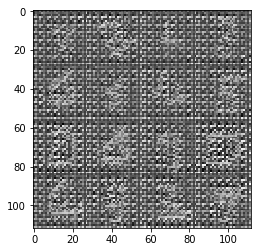

Epoch 2/2... Discriminator Loss: 2.0639... Generator Loss: 0.3913
Epoch 2/2... Discriminator Loss: 0.4933... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 1.6413... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.9967
Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 2.3228... Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 1.1009
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 2.1527


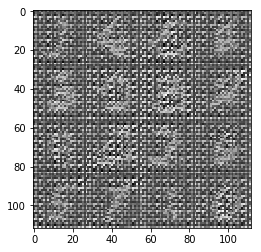

Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 1.9756... Generator Loss: 0.3887
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 2.9723
Epoch 2/2... Discriminator Loss: 1.7931... Generator Loss: 0.4491
Epoch 2/2... Discriminator Loss: 2.0749... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 1.9904... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.8680


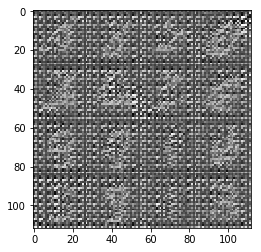

Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 3.0006
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.7660
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 2.0378... Generator Loss: 0.3955
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 2.5378
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 1.5367
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.6805
Epoch 2/2... Discriminator Loss: 2.0179... Generator Loss: 0.3910


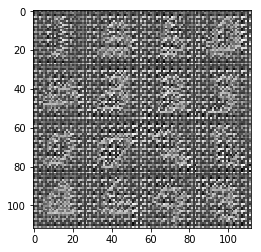

Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.6073
Epoch 2/2... Discriminator Loss: 0.4342... Generator Loss: 2.3934
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.6081
Epoch 2/2... Discriminator Loss: 1.7844... Generator Loss: 0.4623
Epoch 2/2... Discriminator Loss: 2.9613... Generator Loss: 0.3549
Epoch 2/2... Discriminator Loss: 2.0948... Generator Loss: 0.3794
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.1293
Epoch 2/2... Discriminator Loss: 1.4976... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.4030


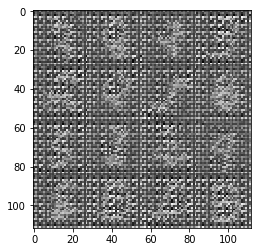

Epoch 2/2... Discriminator Loss: 2.5820... Generator Loss: 0.3750
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 1.6509... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.6485... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 1.9498... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.1484


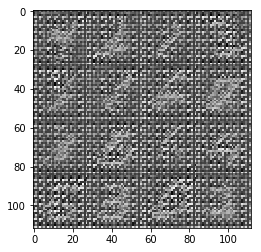

Epoch 2/2... Discriminator Loss: 0.4232... Generator Loss: 2.4430
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.3492
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.2008
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.3010


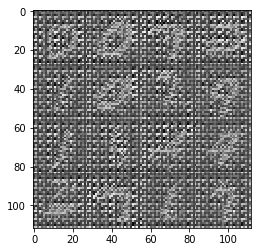

Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.6832
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 2.8442
Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.9363
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.6035


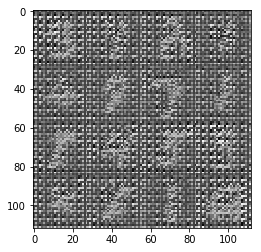

Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 0.3913... Generator Loss: 3.1533
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 3.1611
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 2.3706
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.2546


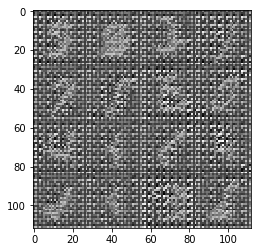

Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.0590
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 5.5364
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 3.0040
Epoch 2/2... Discriminator Loss: 1.5776... Generator Loss: 2.2351
Epoch 2/2... Discriminator Loss: 1.7458... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.5850


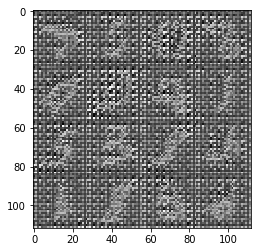

Epoch 2/2... Discriminator Loss: 2.5504... Generator Loss: 0.3458
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 2.0848... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 2.3046
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: 2.4345... Generator Loss: 0.3608
Epoch 2/2... Discriminator Loss: 2.0806... Generator Loss: 0.3763
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.9418


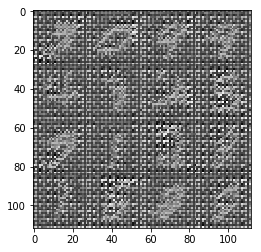

Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.2367
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 3.2515
Epoch 2/2... Discriminator Loss: 2.0656... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 3.5145
Epoch 2/2... Discriminator Loss: 2.0965... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 2.0260... Generator Loss: 0.4400
Epoch 2/2... Discriminator Loss: 1.5002... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 0.5083


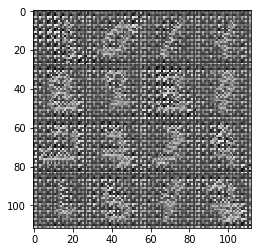

Epoch 2/2... Discriminator Loss: 2.1038... Generator Loss: 0.3666
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 2.9515... Generator Loss: 0.3413
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 2.2561
Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.7662


In [49]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8436... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 2.9267... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 3.2340... Generator Loss: 0.3542
Epoch 1/1... Discriminator Loss: 2.0306... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 2.7313... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.8852
Epoch 1/1... Discriminator Loss: 1.9520... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.8120... Generator Loss: 0.5044


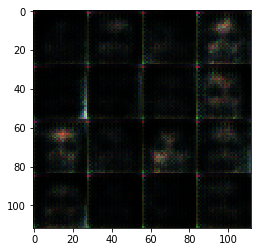

Epoch 1/1... Discriminator Loss: 2.0720... Generator Loss: 0.3569
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 5.1702
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 3.7352
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.4535
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 5.9447
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 5.8312
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.1560


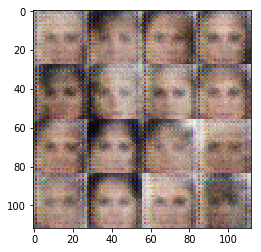

Epoch 1/1... Discriminator Loss: 3.1288... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 5.4218
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.8375
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 5.9531
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 2.9786... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 2.7115


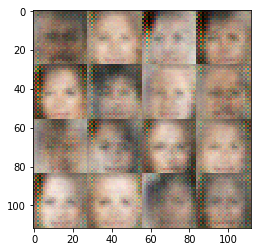

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 2.3143... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.9386
Epoch 1/1... Discriminator Loss: 2.2921... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 3.9247
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 3.8364


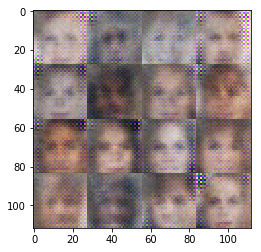

Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 2.7227
Epoch 1/1... Discriminator Loss: 2.4163... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 2.2193... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 5.0746
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 4.9411


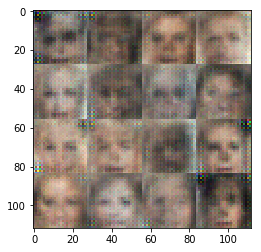

Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 7.4097
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 2.5240
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 6.3261
Epoch 1/1... Discriminator Loss: 2.0017... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6315


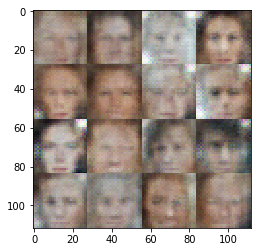

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 8.2739
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 5.5988
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.0876
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 3.3553
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 3.3282


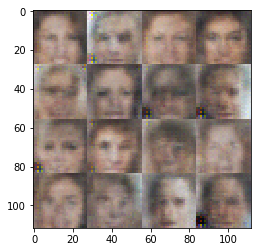

Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 8.4784
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 2.4727
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 5.8858
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.2841


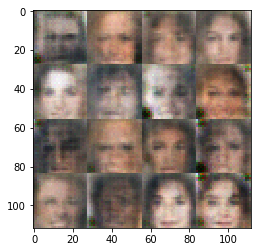

Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.0222
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 2.8838
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 3.1459
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 5.5813
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.7969


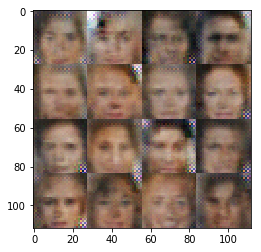

Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 6.7816
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 7.7468
Epoch 1/1... Discriminator Loss: 2.4180... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 4.4470
Epoch 1/1... Discriminator Loss: 1.9469... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 2.1514
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 2.5826... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.2525


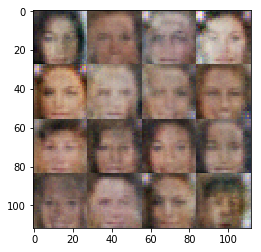

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 3.6250
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 2.8567
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 1.2059


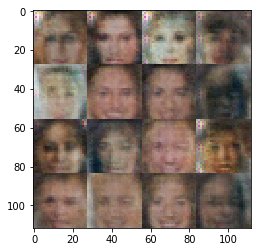

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.8792
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 2.6282
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 3.5390
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.1615
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 3.9190


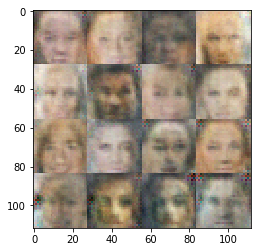

Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 4.5609
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 2.2667
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 2.6700
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 2.0897... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 5.7272
Epoch 1/1... Discriminator Loss: 2.5684... Generator Loss: 3.7132
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.0255
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 1.2918


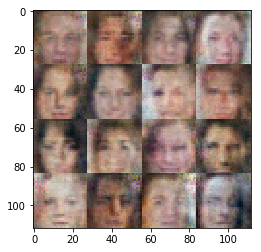

Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 2.8315
Epoch 1/1... Discriminator Loss: 1.9485... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.4043
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 4.5630
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 6.7984
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 7.6176
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 4.5701
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 3.9455


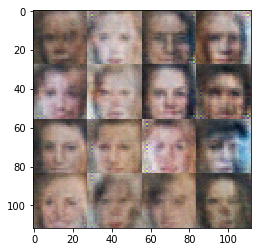

Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 2.5609
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 9.8304
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 2.6131
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 6.2069
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 4.9392


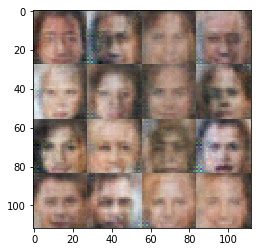

Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 5.2425
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.4579
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 3.3330
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 7.5599
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.4245
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 4.2593


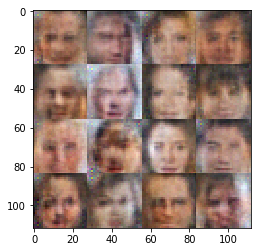

Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 3.9965
Epoch 1/1... Discriminator Loss: 1.9314... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.9522... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.2873
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 6.7686
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.8854
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 2.3367
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.2256


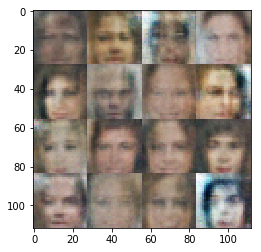

Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 7.1933
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 8.9812
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 2.6250
Epoch 1/1... Discriminator Loss: 2.6057... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 5.6510
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 5.2544
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.6681


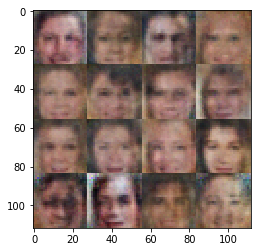

Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 6.1306
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 5.0769
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 3.8883
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 2.4245
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 5.6764
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.6353


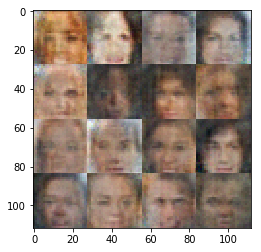

Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.7907
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 3.9847
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 3.5377
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 2.0191
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 2.7783... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.0262
Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 5.5311


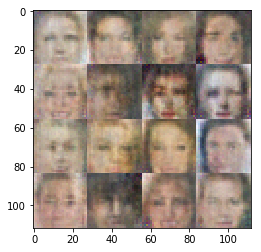

Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 5.3805
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.9117
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 4.5616
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 6.9660
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 5.1844
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 2.2222
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 4.5795


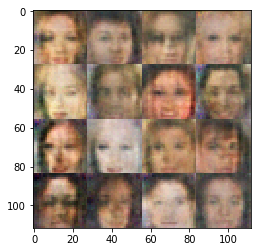

Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.3513
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 5.8919
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 7.6646
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.5217


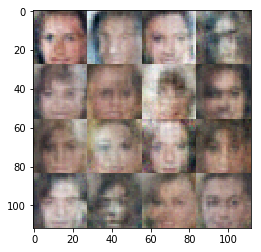

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 3.2751
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 4.5334
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4764
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 6.1849
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 2.7079
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 2.8901


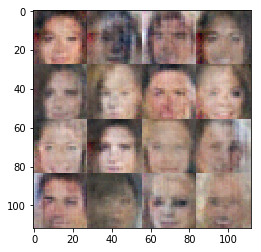

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 3.0933
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.8320... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.5016


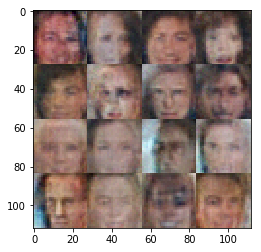

Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.8064... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.8732... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 1.8095... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7411


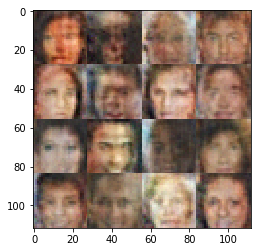

Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.8470... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.8948... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.9367... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 2.0637... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.8078... Generator Loss: 0.4106


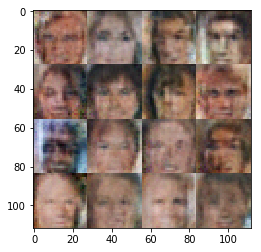

Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 1.9266
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 4.2065
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.8547


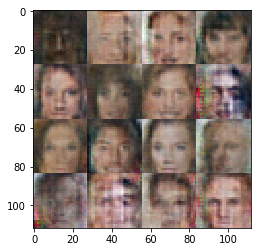

Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 4.5631
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.6162
Epoch 1/1... Discriminator Loss: 2.3038... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 2.3692... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 8.8349
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 7.3100
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 4.5941


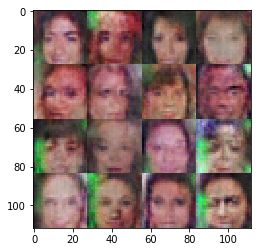

Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 3.9524
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 3.8354
Epoch 1/1... Discriminator Loss: 2.5325... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 3.7723
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.5968
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 5.5297
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.5799


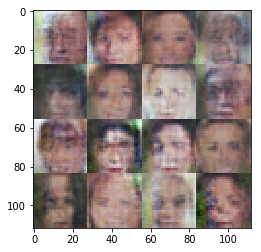

Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.8976
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.8357... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 2.4721... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 4.3606
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 4.2547
Epoch 1/1... Discriminator Loss: 1.6291... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7050


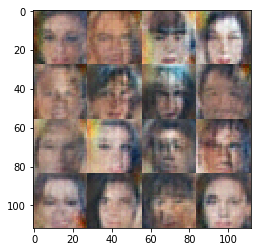

Epoch 1/1... Discriminator Loss: 3.5556... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 3.4985
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 5.4456
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.1816
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 1.8584... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.4553


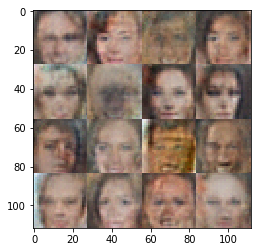

Epoch 1/1... Discriminator Loss: 1.9259... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 2.0612... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 2.0631... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.0024
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 7.0099


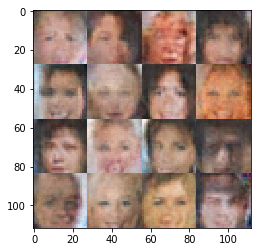

Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 5.3609
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 3.7673
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.8975... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 8.5250
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 4.2963


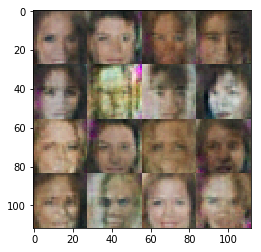

Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 5.4753
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 2.3386
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 3.8913
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 3.8404
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.7963
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 6.7181
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 3.7111
Epoch 1/1... Discriminator Loss: 2.1621... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.4272


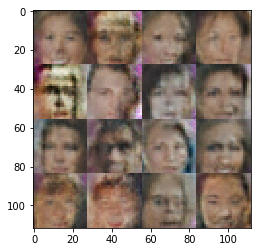

Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.2646
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 5.1015
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 3.9188
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 2.9286
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.3871


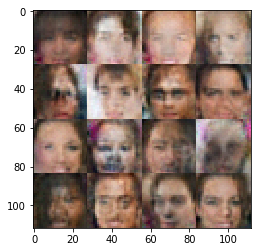

Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 3.0701
Epoch 1/1... Discriminator Loss: 2.5111... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 2.4991
Epoch 1/1... Discriminator Loss: 1.8211... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 4.5802
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.3634
Epoch 1/1... Discriminator Loss: 1.8348... Generator Loss: 0.4327


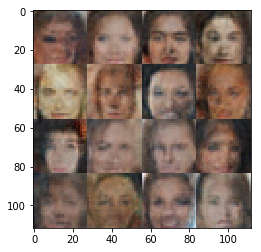

Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 2.2037... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.8764... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.8849... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 2.2493... Generator Loss: 0.3417


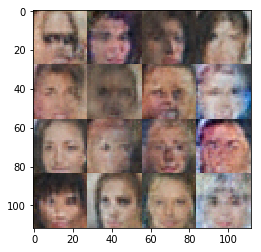

Epoch 1/1... Discriminator Loss: 1.8039... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 2.2575... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.9889... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.9091... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.9173... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.9187... Generator Loss: 0.3823


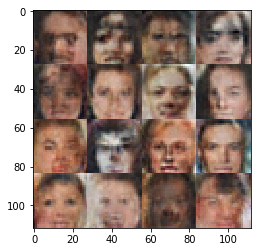

Epoch 1/1... Discriminator Loss: 1.9503... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.8402... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.8099... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 2.2148... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.9731... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 2.0035... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.9756... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 2.3314... Generator Loss: 0.3733


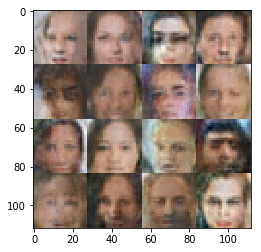

Epoch 1/1... Discriminator Loss: 1.9745... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 2.0879... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.7744... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 2.0970... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 2.0400... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 2.1011... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.9595... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 2.0708... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 1.9156... Generator Loss: 0.3870


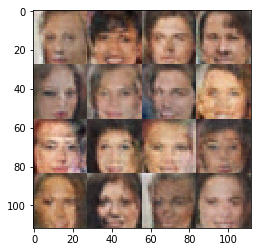

Epoch 1/1... Discriminator Loss: 2.0916... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 2.0763... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 2.3064... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 2.4149... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 2.1142... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.6423
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 2.0888... Generator Loss: 0.3652


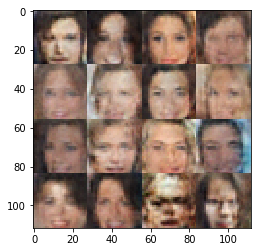

Epoch 1/1... Discriminator Loss: 2.3088... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 2.0471... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 2.2857... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 2.3037... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 2.8530... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.8033... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 2.2773... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.8399... Generator Loss: 0.4445


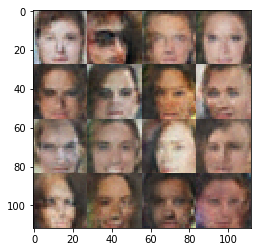

Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 2.2502... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 2.2235... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.9487... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 2.0098... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 2.0792... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 2.2122... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 2.2466... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 2.1437... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 2.1402... Generator Loss: 0.3582


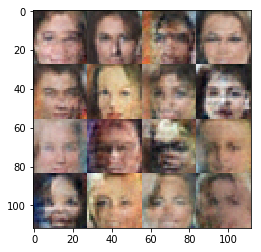

Epoch 1/1... Discriminator Loss: 2.1061... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 2.1240... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 2.2090... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.9828... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 2.1592... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.9240... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 2.1962... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 2.6732... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 2.5895


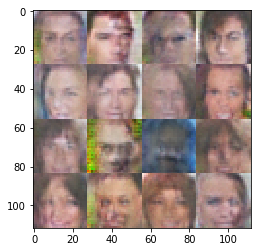

Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.4539


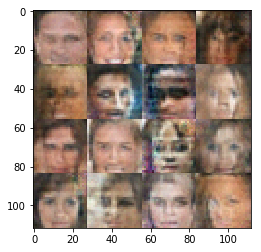

Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 2.4374
Epoch 1/1... Discriminator Loss: 2.5300... Generator Loss: 0.3363
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 4.9877
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.6050
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 2.7343
Epoch 1/1... Discriminator Loss: 2.1525... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 2.3052


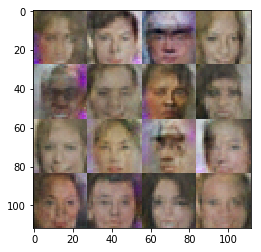

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 3.9328
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 6.4316
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.1980
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 4.1286
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 4.5725
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 8.9989
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 2.7133


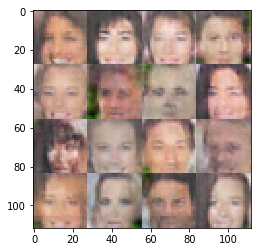

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 4.8175
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 2.1699
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.9467... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 5.0178
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.2378
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.2847


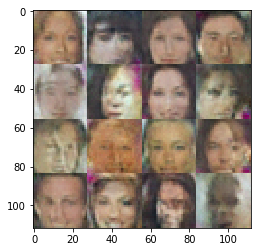

Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 4.3211
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 5.0319
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 5.7870
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.8173... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 2.9097
Epoch 1/1... Discriminator Loss: 1.8618... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 4.9700


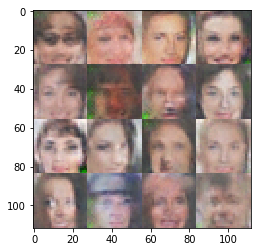

Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.8772... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 2.0316... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.7011... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 2.0240... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 2.1489... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 2.2154... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 2.0434... Generator Loss: 0.4216


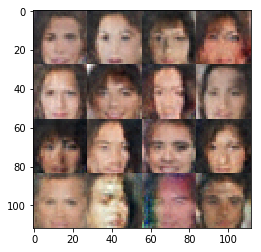

KeyboardInterrupt: 

In [50]:
# I stopped when it generates realistic faces
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.